In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 194kB 16.0MB/s 
     |████████████████████████████████| 1.2MB 15.8MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 12.8MB 223kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
# unzip files
# do once
classes = 'mask','no_mask'
path = Path('/content/face_data')
print(path)
#do once
for c in classes:
  myfile = c + '.zip'
  print(myfile)
  with zipfile.ZipFile(path/myfile,"r") as zip_ref:
    zip_ref.extractall(path/c)

/content/face_data
mask.zip
no_mask.zip


In [ ]:
#verify image files and delete any that are problematic
fnames = get_image_files(path)
failed = verify_images(fnames)
failed.map(Path.unlink)
     

(#0) []

## Data block

In [ ]:
# create DataBlock
faces = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y=parent_label,
                 splitter=RandomSplitter(seed=42),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
# read data
dls = faces.dataloaders(path, batch_size=8)

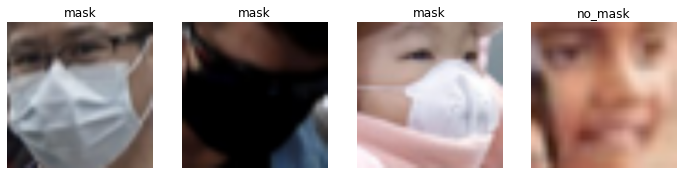

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)


## Learner and Training

In [ ]:
## we'll use fine_tune to speed up this demo
# create Learner
learn = cnn_learner(dls, resnet34, metrics=error_rate)

# Save the model before any training
learn.save("faces_initial")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Path('models/faces_initial.pth')

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=6.309573450380412e-07)

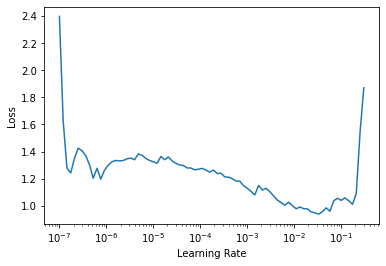

In [ ]:
# Find optimal learning raet for the head
learn.lr_find()

In [ ]:
# Load the intial model to ensure that we train on head of base model
learn.load("faces_initial")

# It seems that 1e-3 seems like a good learning rate, train head at this rate for 3 epochs
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.374780,0.150419,0.052770,00:19
1,0.228109,0.061414,0.021108,00:19
2,0.157603,0.062040,0.021108,00:19


In [ ]:
#Save trainer
learn.save("faces_head")

Path('models/faces_head.pth')

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=1.5848931980144698e-06)

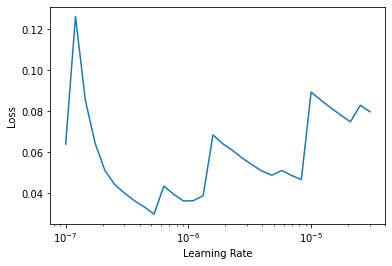

In [ ]:
# Load and unfreeze the model
learn.load('faces_head')
learn.unfreeze()

# Find optimal learning rate for whole model
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=slice(1e-7, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.191506,0.077965,0.026385,00:24
1,0.141648,0.051998,0.021108,00:24
2,0.170588,0.050509,0.018470,00:24
3,0.146108,0.049155,0.010554,00:24
4,0.149524,0.062221,0.023747,00:24
5,0.147843,0.051900,0.015831,00:24
6,0.170153,0.055878,0.021108,00:24
7,0.133492,0.059063,0.015831,00:24
8,0.139145,0.055580,0.015831,00:24
9,0.161826,0.072402,0.026385,00:24


In [ ]:
# Load and unfreeze the model
learn.load('faces_head')
learn.unfreeze()

# Train for 2 cycles
learn.fit_one_cycle(20, lr_max=slice(1e-6, 1e-5))

## Model interpretation

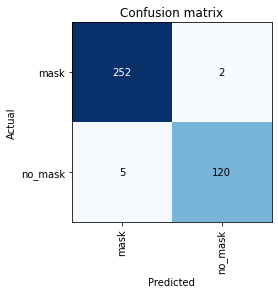

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

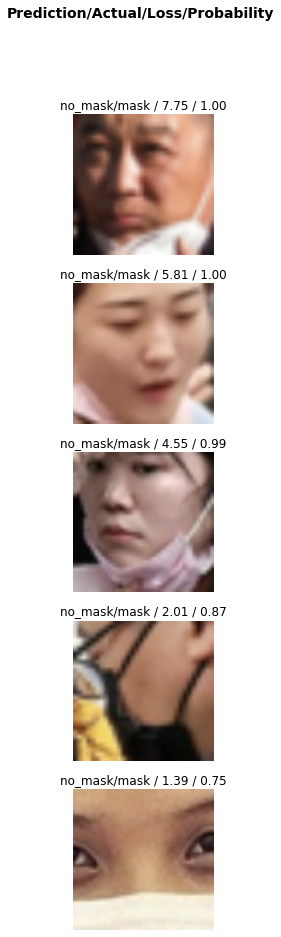

In [ ]:
interp.plot_top_losses(5, nrows=5)

### Using the Model for Inference

In [ ]:
# Export model to use the CPU for prediction
learn.model = learn.model.cpu()
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]